R langauge colab

In [ ]:
View(data)

function (..., list = character(), package = NULL, lib.loc = NULL, 
    verbose = getOption("verbose"), envir = .GlobalEnv, overwrite = TRUE) 
{
    fileExt <- function(x) {
        db <- grepl("\\.[^.]+\\.(gz|bz2|xz)$", x)
        ans <- sub(".*\\.", "", x)
        ans[db] <- sub(".*\\.([^.]+\\.)(gz|bz2|xz)$", "\\1\\2", 
            x[db])
        ans
    }
    my_read_table <- function(...) {
        lcc <- Sys.getlocale("LC_COLLATE")
        on.exit(Sys.setlocale("LC_COLLATE", lcc))
        Sys.setlocale("LC_COLLATE", "C")
        read.table(...)
    }
    names <- c(as.character(substitute(list(...))[-1L]), list)
    if (!is.null(package)) {
        if (!is.character(package)) 
            stop("'package' must be a character string or NULL")
        if (FALSE) {
            if (any(package %in% "base")) 
                warning("datasets have been moved from package 'base' to package 'datasets'")
            if (any(package %in% "stats")) 
                warning("datasets have been moved from package 'stats' to package 'datasets'")
            package[package %in% c("base", "stats")] <- "datasets"
        }
    }
    paths <- find.package(package, lib.loc, verbose = verbose)
    if (is.null(lib.loc)) 
        paths <- c(path.package(package, TRUE), if (!length(package)) getwd(), 
            paths)
    paths <- unique(normalizePath(paths[file.exists(paths)]))
    paths <- paths[dir.exists(file.path(paths, "data"))]
    dataExts <- tools:::.make_file_exts("data")
    if (length(names) == 0L) {
        db <- matrix(character(), nrow = 0L, ncol = 4L)
        for (path in paths) {
            entries <- NULL
            packageName <- if (file_test("-f", file.path(path, 
                "DESCRIPTION"))) 
                basename(path)
            else "."
            if (file_test("-f", INDEX <- file.path(path, "Meta", 
                "data.rds"))) {
                entries <- readRDS(INDEX)
            }
            else {
                dataDir <- file.path(path, "data")
                entries <- tools::list_files_with_type(dataDir, 
                  "data")
                if (length(entries)) {
                  entries <- unique(tools::file_path_sans_ext(basename(entries)))
                  entries <- cbind(entries, "")
                }
            }
            if (NROW(entries)) {
                if (is.matrix(entries) && ncol(entries) == 2L) 
                  db <- rbind(db, cbind(packageName, dirname(path), 
                    entries))
                else warning(gettextf("data index for package %s is invalid and will be ignored", 
                  sQuote(packageName)), domain = NA, call. = FALSE)
            }
        }
        colnames(db) <- c("Package", "LibPath", "Item", "Title")
        footer <- if (missing(package)) 
            paste0("Use ", sQuote(paste("data(package =", ".packages(all.available = TRUE))")), 
                "\n", "to list the data sets in all *available* packages.")
        else NULL
        y <- list(title = "Data sets", header = NULL, results = db, 
            footer = footer)
        class(y) <- "packageIQR"
        return(y)
    }
    paths <- file.path(paths, "data")
    for (name in names) {
        found <- FALSE
        for (p in paths) {
            tmp_env <- if (overwrite) 
                envir
            else new.env()
            if (file_test("-f", file.path(p, "Rdata.rds"))) {
                rds <- readRDS(file.path(p, "Rdata.rds"))
                if (name %in% names(rds)) {
                  found <- TRUE
                  if (verbose) 
                    message(sprintf("name=%s:\t found in Rdata.rds", 
                      name), domain = NA)
                  thispkg <- sub(".*/([^/]*)/data$", "\\1", p)
                  thispkg <- sub("_.*$", "", thispkg)
                  thispkg <- paste0("package:", thispkg)
                  objs <- rds[[name]]
                  lazyLoad(file.path(p, "Rdata"), envir = tmp_env, 
                    filter = functio

In [ ]:
install.packages("ggalt")
install.packages("countrycode")
install.packages("rworldmap")
install.packages("gridExtra")
install.packages("broom")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘later’, ‘extrafontdb’, ‘Rttf2pt1’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘proj4’, ‘ash’, ‘maps’, ‘extrafont’, ‘plotly’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dotCall64’, ‘gridExtra’, ‘spam’, ‘viridis’, ‘sp’, ‘maptools’, ‘fields’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(tidyverse) # general
library(ggalt) # dumbbell plots
library(countrycode) # continent
library(rworldmap) # quick country-level heat maps
library(gridExtra) # plots
library(broom) # significant trends within countries

theme_set(theme_light())


# 1) Import & data cleaning

data <- read_csv("master.csv") 

# glimpse(data) # will tidy up these variable names

# sum(is.na(data$`HDI for year`)) # remove, > 2/3 missing, not useable

# table(data$age, data$generation) # don't like this variable

data <- data %>% 
  select(-c(`HDI for year`, `suicides/100k pop`)) %>%
  rename(gdp_for_year = `gdp_for_year ($)`, 
         gdp_per_capita = `gdp_per_capita ($)`, 
         country_year = `country-year`) %>%
  as.data.frame()



# 2) OTHER ISSUES

# a) this SHOULD give 12 rows for every county-year combination (6 age bands * 2 genders):

# data %>% 
#   group_by(country_year) %>%
#   count() %>%
#   filter(n != 12) # note: there appears to be an issue with 2016 data
# not only are there few countries with data, but those that do have data are incomplete

data <- data %>%
  filter(year != 2016) %>% # I therefore exclude 2016 data
  select(-country_year)


# b) excluding countries with <= 3 years of data:

minimum_years <- data %>%
  group_by(country) %>%
  summarize(rows = n(), 
            years = rows / 12) %>%
  arrange(years)

data <- data %>%
  filter(!(country %in% head(minimum_years$country, 7)))


# no other major data issues found yet



# 3) TIDYING DATAFRAME
data$age <- gsub(" years", "", data$age)
data$sex <- ifelse(data$sex == "male", "Male", "Female")


# getting continent data:
data$continent <- countrycode(sourcevar = data[, "country"],
                              origin = "country.name",
                              destination = "continent")

# Nominal factors
data_nominal <- c('country', 'sex', 'continent')
data[data_nominal] <- lapply(data[data_nominal], function(x){factor(x)})


# Making age ordinal
data$age <- factor(data$age, 
                   ordered = T, 
                   levels = c("5-14",
                              "15-24", 
                              "25-34", 
                              "35-54", 
                              "55-74", 
                              "75+"))

# Making generation ordinal
data$generation <- factor(data$generation, 
                   ordered = T, 
                   levels = c("G.I. Generation", 
                              "Silent",
                              "Boomers", 
                              "Generation X", 
                              "Millenials", 
                              "Generation Z"))

data <- as_tibble(data)


# the global rate over the time period will be useful:

global_average <- (sum(as.numeric(data$suicides_no)) / sum(as.numeric(data$population))) * 100000

# view the finalized data
glimpse(data)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2

Loading required package: sp

### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



── Column specification ─────────────────

Rows: 27,492
Columns: 10
$ country        <fct> Albania, Albania, Albania, Albania, Albania, Albania, A…
$ year           <dbl> 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1…
$ sex            <fct> Male, Male, Female, Male, Male, Female, Female, Female,…
$ age            <ord> 15-24, 35-54, 15-24, 75+, 25-34, 75+, 35-54, 25-34, 55-…
$ suicides_no    <dbl> 21, 16, 14, 1, 9, 1, 6, 4, 1, 0, 0, 0, 2, 17, 1, 14, 4,…
$ population     <dbl> 312900, 308000, 289700, 21800, 274300, 35600, 278800, 2…
$ gdp_for_year   <dbl> 2156624900, 2156624900, 2156624900, 2156624900, 2156624…
$ gdp_per_capita <dbl> 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, …
$ generation     <ord> Generation X, Silent, Generation X, G.I. Generation, Bo…
$ continent      <fct> Europe, Europe, Europe, Europe, Europe, Europe, Europe,…


In [ ]:
data <- read_csv("master.csv") 
data <- data %>% 
  select(-c(`HDI for year`, `suicides/100k pop`)) %>%
  rename(gdp_for_year = `gdp_for_year ($)`, 
         gdp_per_capita = `gdp_per_capita ($)`, 
         country_year = `country-year`) %>%
  as.data.frame()



# 2) OTHER ISSUES

# a) this SHOULD give 12 rows for every county-year combination (6 age bands * 2 genders):

# data %>% 
#   group_by(country_year) %>%
#   count() %>%
#   filter(n != 12) # note: there appears to be an issue with 2016 data
# not only are there few countries with data, but those that do have data are incomplete

data <- data %>%
  filter(year != 2016) %>% # I therefore exclude 2016 data
  select(-country_year)


# b) excluding countries with <= 3 years of data:

minimum_years <- data %>%
  group_by(country) %>%
  summarize(rows = n(), 
            years = rows / 12) %>%
  arrange(years)


── Column specification ────────────────────────────────────────────────────────
cols(
  country = col_character(),
  year = col_double(),
  sex = col_character(),
  age = col_character(),
  suicides_no = col_double(),
  population = col_double(),
  `suicides/100k pop` = col_double(),
  `country-year` = col_character(),
  `HDI for year` = col_double(),
  `gdp_for_year ($)` = col_number(),
  `gdp_per_capita ($)` = col_double(),
  generation = col_character()
)




In [ ]:
minimum_years
data <- data %>%
  filter(!(country %in% head(minimum_years$country, 7)))

country,rows,years
<chr>,<int>,<dbl>
Cabo Verde,12,1
Dominica,12,1
Macau,12,1
Bosnia and Herzegovina,24,2
Oman,36,3
Saint Kitts and Nevis,36,3
San Marino,36,3
Nicaragua,72,6
United Arab Emirates,72,6


In [ ]:
data %>%
  group_by(country)

country,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita,generation
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Albania,1987,male,15-24 years,21,312900,2156624900,796,Generation X
Albania,1987,male,35-54 years,16,308000,2156624900,796,Silent
Albania,1987,female,15-24 years,14,289700,2156624900,796,Generation X
Albania,1987,male,75+ years,1,21800,2156624900,796,G.I. Generation
Albania,1987,male,25-34 years,9,274300,2156624900,796,Boomers
Albania,1987,female,75+ years,1,35600,2156624900,796,G.I. Generation
Albania,1987,female,35-54 years,6,278800,2156624900,796,Silent
Albania,1987,female,25-34 years,4,257200,2156624900,796,Boomers
Albania,1987,male,55-74 years,1,137500,2156624900,796,G.I. Generation


In [ ]:
write.csv(data, "processed_master.csv")

In [ ]:
country_year_gdp <- data %>%
  group_by(country, year) %>%
  summarize(gdp_per_capita = mean(gdp_per_capita))
  
country_year_gdp_corr <- country_year_gdp %>%
  ungroup() %>%
  group_by(country) %>%
  summarize(year_gdp_correlation = cor(year, gdp_per_capita))

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



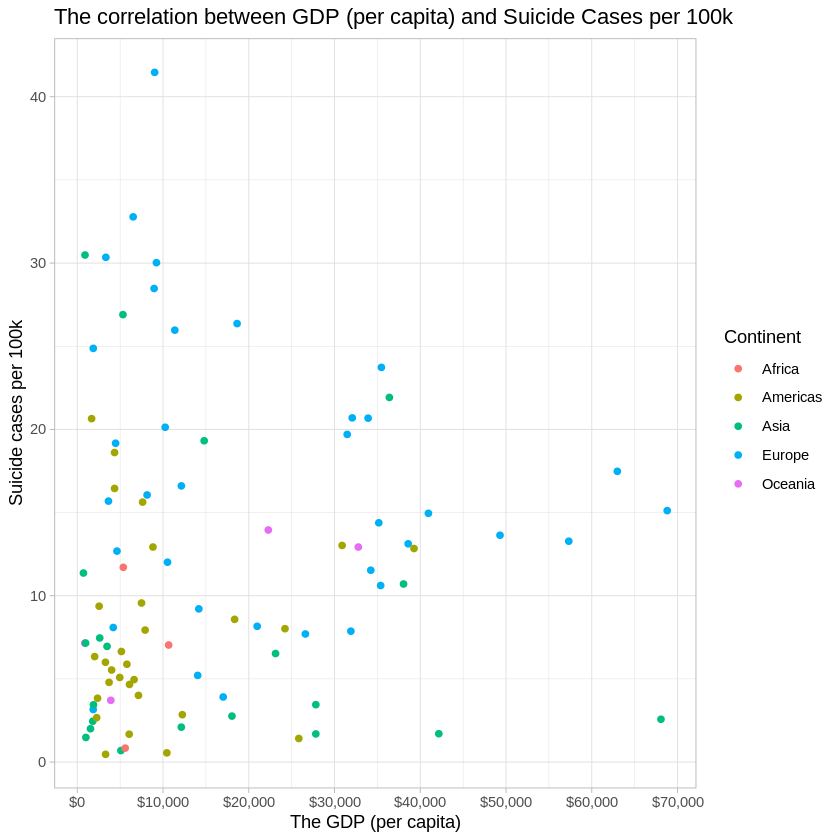

In [ ]:
country_mean_gdp <- data %>%
  group_by(country, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000, 
            gdp_per_capita = mean(gdp_per_capita))

ggplot(country_mean_gdp, aes(x = gdp_per_capita, y = suicide_per_100k, col = continent)) + 
  geom_point() + 
  scale_x_continuous(labels=scales::dollar_format(prefix="$"), breaks = seq(0, 70000, 10000)) + 
  labs(title = "The correlation between GDP (per capita) and Suicide Cases per 100k",
       x = "The GDP (per capita)", 
       y = "Suicide cases per 100k", 
       col = "Continent") 

In [ ]:
write.csv(country_mean_gdp, "Suicide over GDP.csv")

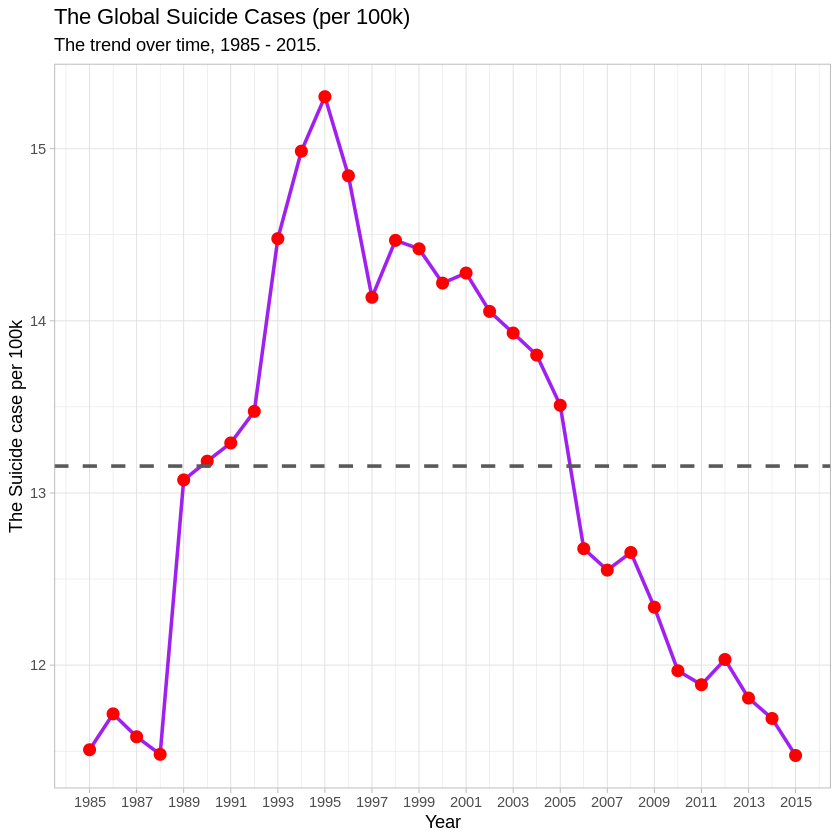

In [ ]:
data %>%
  group_by(year) %>%
  summarize(population = sum(population), 
            suicides = sum(suicides_no), 
            suicides_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = year, y = suicides_per_100k)) + 
  geom_line(col = "purple", size = 1) + 
  geom_point(col = "red", size = 3) + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "The Global Suicide Cases (per 100k)",
       subtitle = "The trend over time, 1985 - 2015.",
       x = "Year", 
       y = "The Suicide case per 100k") + 
  scale_x_continuous(breaks = seq(1985, 2015, 2)) + 
  scale_y_continuous(breaks = seq(10, 20))

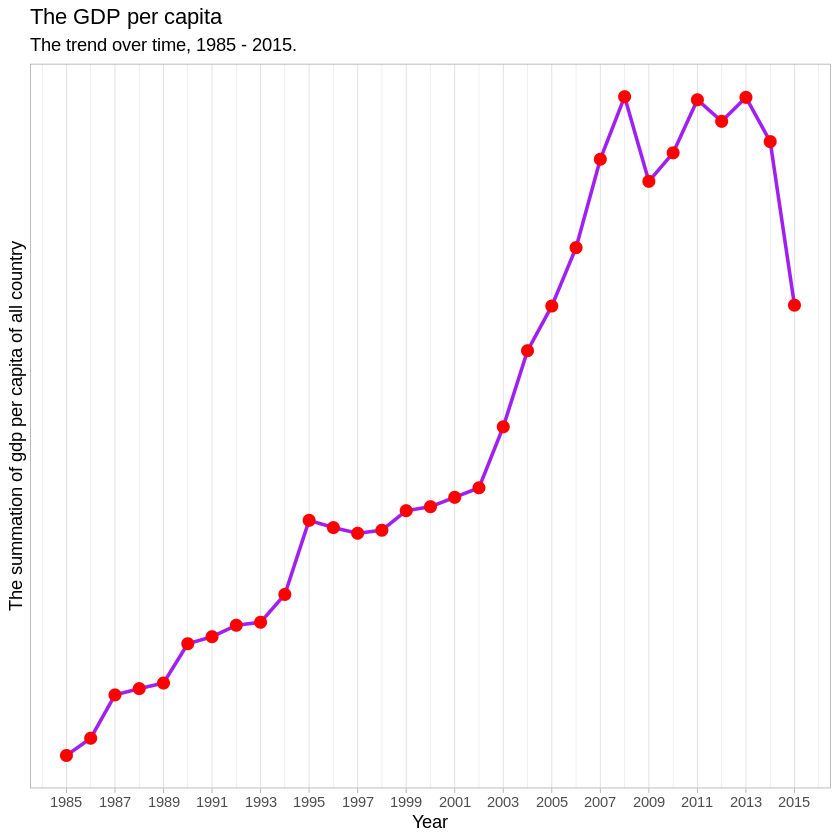

In [ ]:
data %>% group_by(year) %>% summarize(gdp_sort = sum(gdp_per_capita))  %>%
ggplot(aes(x = year, y = gdp_sort)) +
  geom_line(col = "purple", size = 1) + 
  geom_point(col = "red", size = 3)+
  labs(title = "The GDP per capita ",
       subtitle = "The trend over time, 1985 - 2015.",
       x = "Year", 
       y = "The summation of gdp per capita of all country") + 
  scale_x_continuous(breaks = seq(1985, 2015, 2)) + 
  scale_y_continuous(breaks = seq(10, 20))

Task C

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



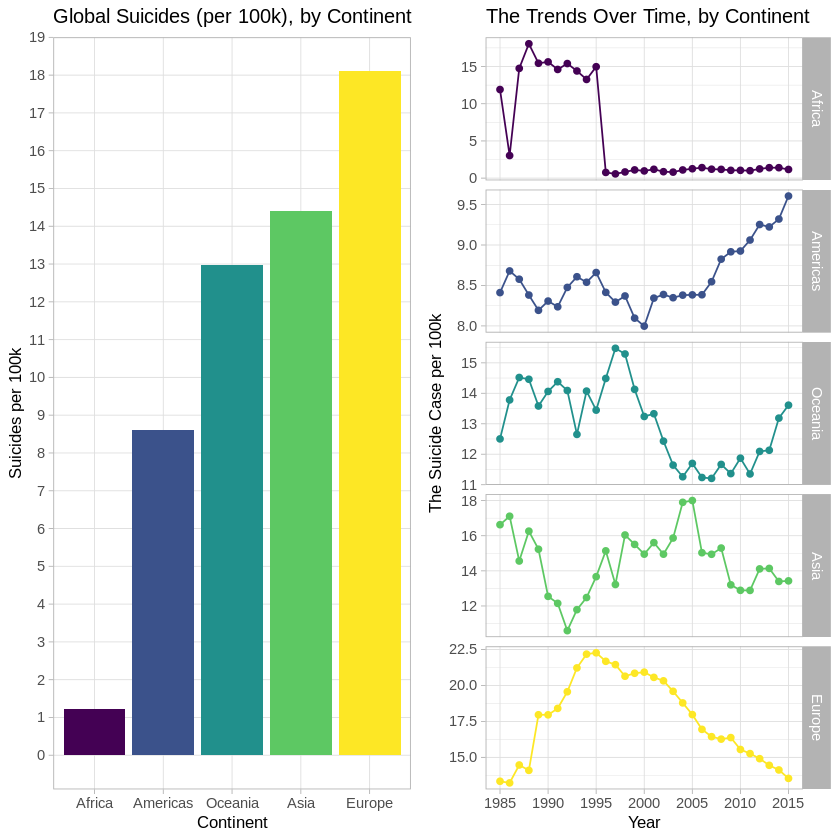

In [ ]:
# Continent
continent <- data %>%
  group_by(continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  arrange(suicide_per_100k)

continent$continent <- factor(continent$continent, ordered = T, levels = continent$continent)

continent_plot <- ggplot(continent, aes(x = continent, y = suicide_per_100k, fill = continent)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global Suicides (per 100k), by Continent",
  x = "Continent", 
  y = "Suicides per 100k", 
  fill = "Continent") +
  theme(legend.position = "none", title = element_text(size = 10)) + 
  scale_y_continuous(breaks = seq(0, 20, 1), minor_breaks = F)


continent_time <- data %>%
  group_by(year, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

continent_time$continent <- factor(continent_time$continent, ordered = T, levels = continent$continent)

continent_time_plot <- ggplot(continent_time, aes(x = year, y = suicide_per_100k, col = factor(continent))) + 
  facet_grid(continent ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "The Trends Over Time, by Continent", 
       x = "Year", 
       y = "The Suicide Case per 100k", 
       color = "Continent") + 
  theme(legend.position = "none", title = element_text(size = 10)) + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)

grid.arrange(continent_plot, continent_time_plot, ncol = 2)

92 codes from your data successfully matched countries in the map
1 codes from your data failed to match with a country code in the map
151 codes from the map weren't represented in your data


You asked for 7 categories, 9 were used due to pretty() classification



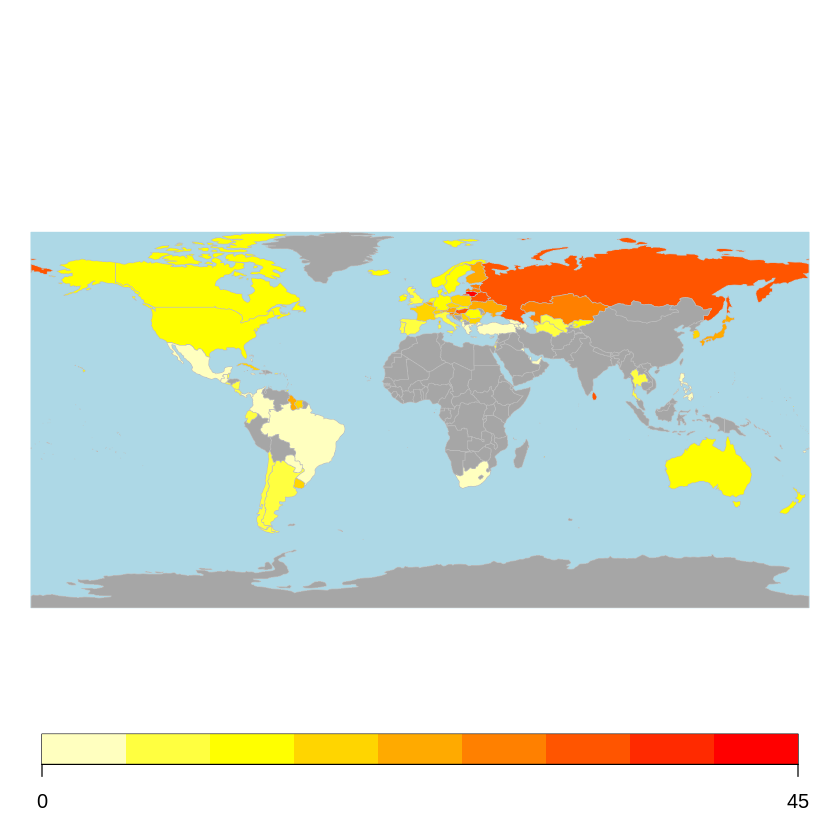

In [ ]:
country <- data %>%
  group_by(country) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

countrydata <- joinCountryData2Map(country, joinCode = "NAME", nameJoinColumn = "country")

par(mar=c(0, 0, 0, 0)) # margins

mapCountryData(countrydata, 
nameColumnToPlot="suicide_per_100k", 
mapTitle="", 
colourPalette = "heat", 
oceanCol="lightblue", 
missingCountryCol="grey65", 
catMethod = "pretty")

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



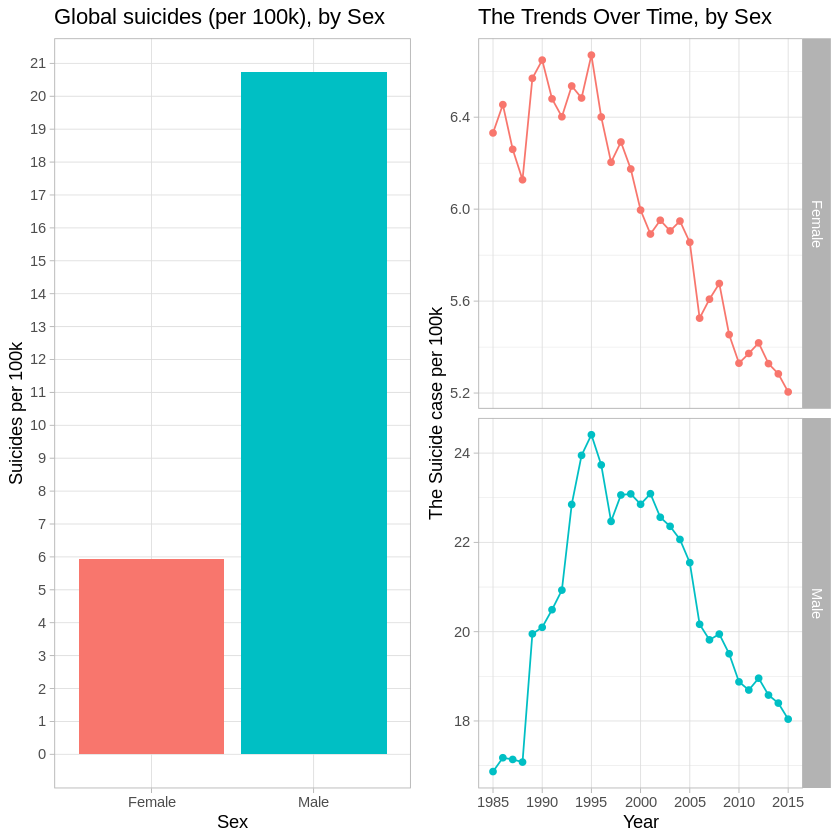

In [ ]:
#Sex
sex_plot <- data %>%
  group_by(sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
ggplot(aes(x = sex, y = suicide_per_100k, fill = sex)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global suicides (per 100k), by Sex",
       x = "Sex", 
       y = "Suicides per 100k") +
  theme(legend.position = "none") + 
  scale_y_continuous(breaks = seq(0, 25), minor_breaks = F)

### with time
sex_time_plot <- data %>%
  group_by(year, sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = factor(sex))) + 
  facet_grid(sex ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "The Trends Over Time, by Sex", 
       x = "Year", 
       y = "The Suicide case per 100k", 
       color = "Sex") + 
  theme(legend.position = "none") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)

grid.arrange(sex_plot, sex_time_plot, ncol = 2)

In [ ]:
summary(data)

      country           year          sex           age        suicides_no     
 Argentina:  372   Min.   :1985   Female:13746   5-14 :4582   Min.   :    0.0  
 Austria  :  372   1st Qu.:1995   Male  :13746   15-24:4582   1st Qu.:    3.0  
 Belgium  :  372   Median :2002                  25-34:4582   Median :   25.0  
 Brazil   :  372   Mean   :2001                  35-54:4582   Mean   :  244.9  
 Chile    :  372   3rd Qu.:2008                  55-74:4582   3rd Qu.:  133.0  
 Colombia :  372   Max.   :2015                  75+  :4582   Max.   :22338.0  
 (Other)  :25260                                                               
   population        gdp_for_year       gdp_per_capita             generation  
 Min.   :     278   Min.   :4.692e+07   Min.   :   251   G.I. Generation:2726  
 1st Qu.:   99298   1st Qu.:9.025e+09   1st Qu.:  3418   Silent         :6298  
 Median :  436562   Median :4.819e+10   Median :  9283   Boomers        :4926  
 Mean   : 1861366   Mean   :4.497e+11   

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



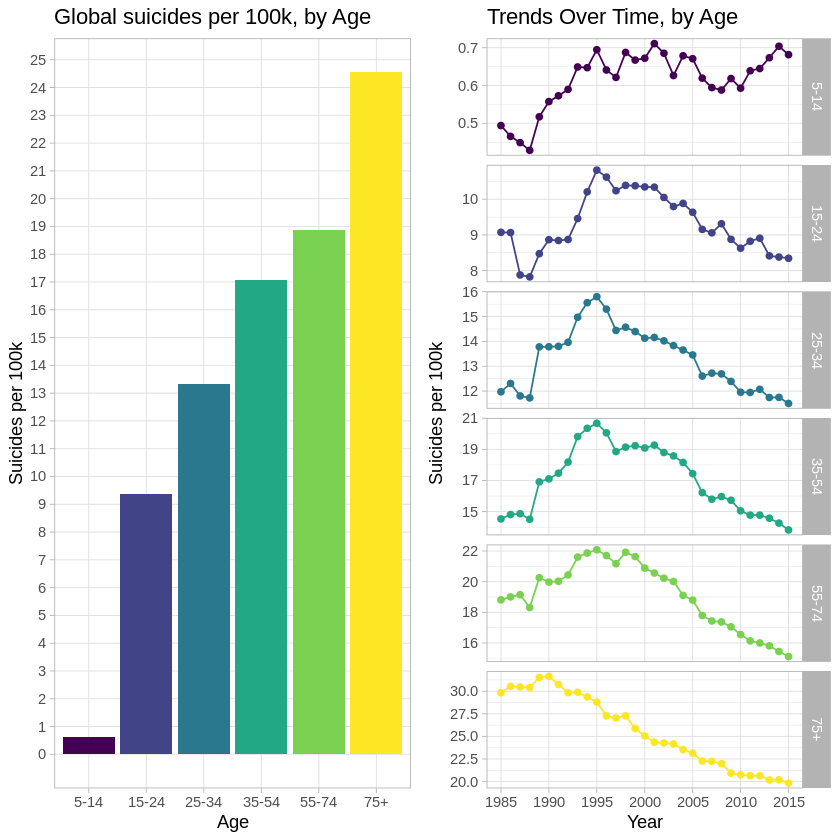

In [ ]:
#age
age_plot <- data %>%
  group_by(age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = age, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global suicides per 100k, by Age",
       x = "Age", 
       y = "Suicides per 100k") +
  theme(legend.position = "none") + 
  scale_y_continuous(breaks = seq(0, 30, 1), minor_breaks = F)

### with time
age_time_plot <- data %>%
  group_by(year, age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = age)) + 
  facet_grid(age ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "Trends Over Time, by Age", 
       x = "Year", 
       y = "Suicides per 100k", 
       color = "Age") + 
  theme(legend.position = "none") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)


grid.arrange(age_plot, age_time_plot, ncol = 2)

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



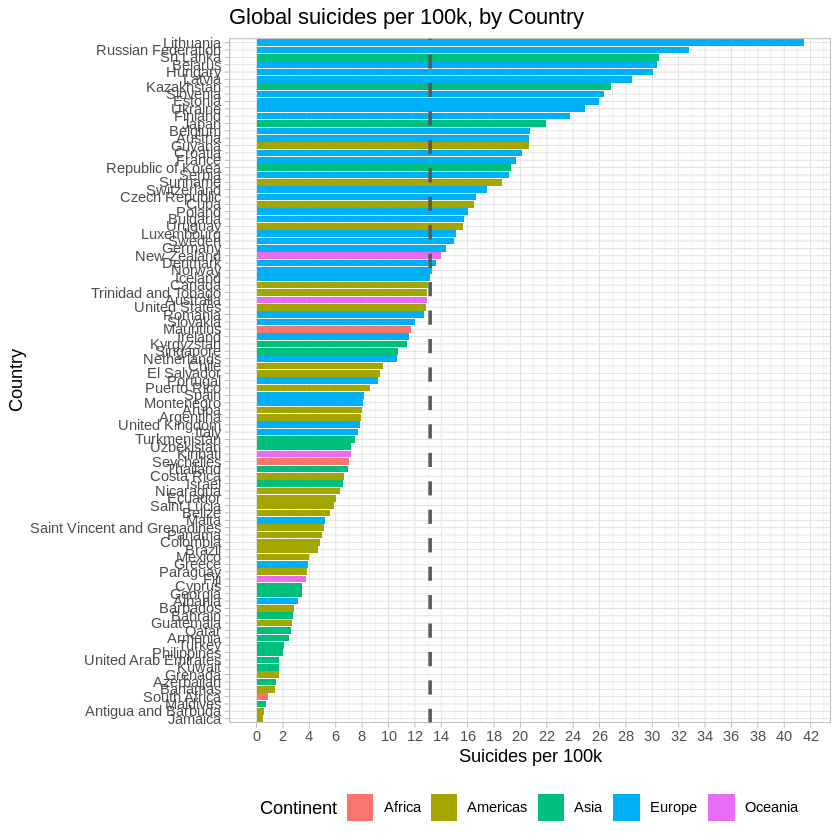

In [ ]:
#country
country <- data %>%
  group_by(country, continent) %>%
  summarize(n = n(), 
            suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  arrange(desc(suicide_per_100k))

country$country <- factor(country$country, 
                          ordered = T, 
                          levels = rev(country$country))

ggplot(country, aes(x = country, y = suicide_per_100k, fill = continent)) + 
  geom_bar(stat = "identity") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Global suicides per 100k, by Country",
       x = "Country", 
       y = "Suicides per 100k", 
       fill = "Continent") +
  coord_flip() +
  scale_y_continuous(breaks = seq(0, 45, 2)) + 
  theme(legend.position = "bottom")

92 codes from your data successfully matched countries in the map
1 codes from your data failed to match with a country code in the map
151 codes from the map weren't represented in your data


You asked for 7 categories, 9 were used due to pretty() classification

You asked for 7 categories, 9 were used due to pretty() classification



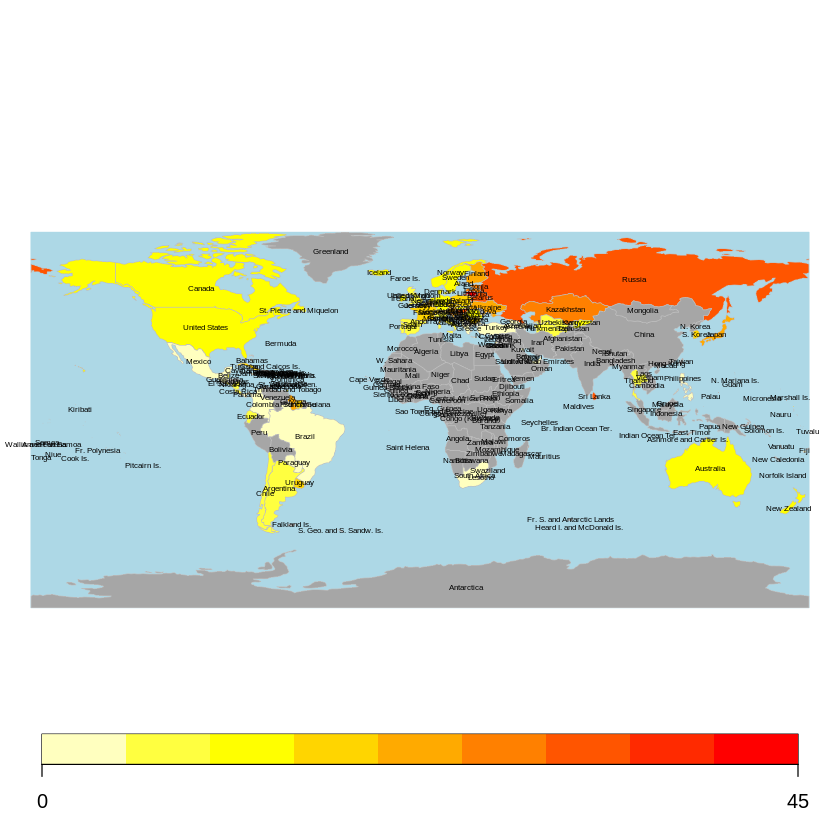

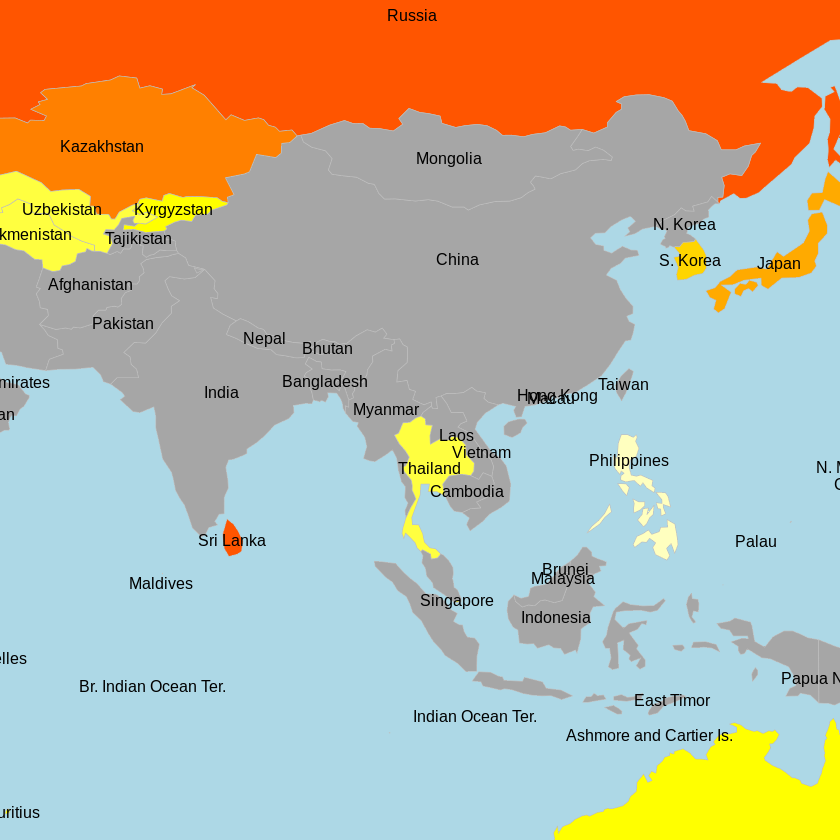

In [ ]:
#
country <- data %>%
  group_by(country) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

countrydata <- joinCountryData2Map(country, joinCode = "NAME", nameJoinColumn = "country")

par(mar=c(0, 0, 0, 0)) # margins


mapCountryData(countrydata, 
nameColumnToPlot="suicide_per_100k", 
mapTitle="", 
colourPalette = "heat", 
oceanCol="lightblue", 
missingCountryCol="grey65", 
catMethod = "pretty")
labelCountries(col = "black",cex = 0.4)
#

mapCountryData(countrydata, 
nameColumnToPlot="suicide_per_100k", 
mapTitle="", 
mapRegion = "asia", 
colourPalette = "heat", 
oceanCol="lightblue", 
missingCountryCol="grey65", 
addLegend = FALSE, 
catMethod = "pretty")

labelCountries(col = "black")

`summarise()` has grouped output by 'continent'. You can override using the `.groups` argument.



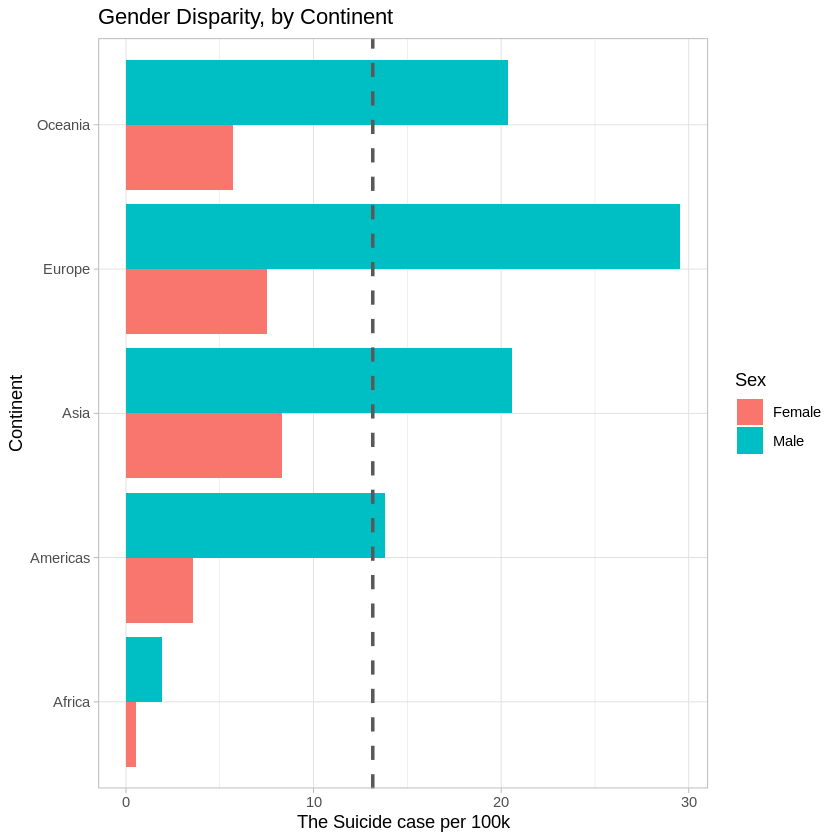

In [ ]:
# gender by contigent
data %>%
  group_by(continent, sex) %>%
  summarize(n = n(), 
            suicides = sum(as.numeric(suicides_no)), 
            population = sum(as.numeric(population)), 
            suicide_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = continent, y = suicide_per_100k, fill = sex)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Gender Disparity, by Continent",
   x = "Continent", 
   y = "The Suicide case per 100k", 
   fill = "Sex") +
  coord_flip()

`summarise()` has grouped output by 'country', 'continent'. You can override using the `.groups` argument.



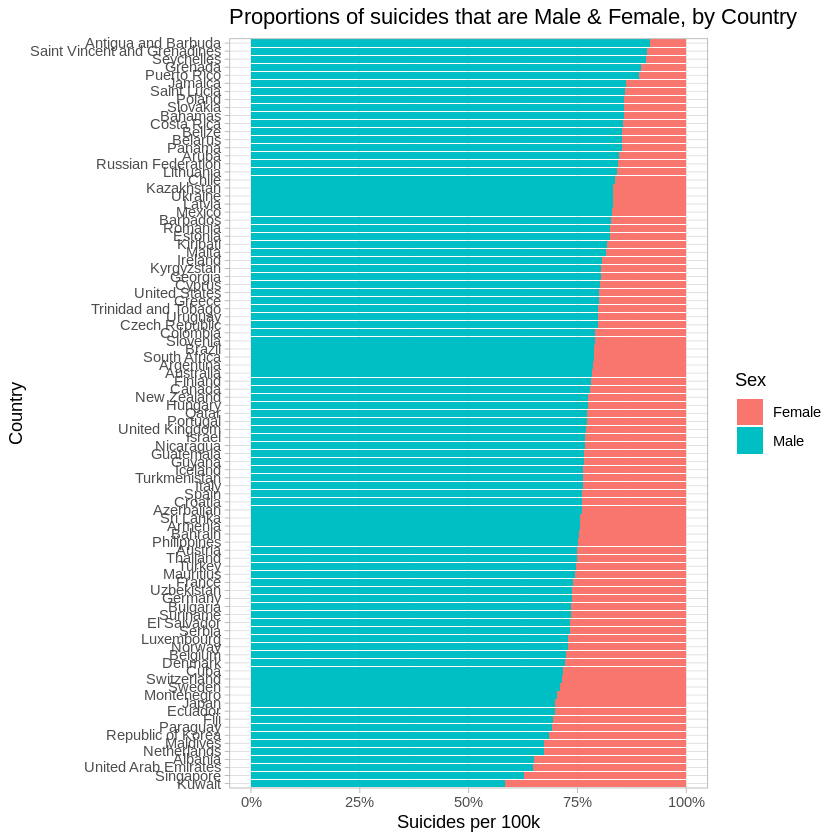

In [ ]:
sex_country_long <- data %>%
  group_by(country, continent, sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)


sex_country_wide <- sex_country_long %>%
  spread(sex, suicide_per_100k) %>%
  arrange(Male - Female)
  
country_gender_prop <- sex_country_wide %>%
  mutate(Male_Proportion = Male / (Female + Male)) %>%
  arrange(Male_Proportion)

sex_country_long$country <- factor(sex_country_long$country, 
                                   ordered = T,
                                   levels = country_gender_prop$country)

ggplot(sex_country_long, aes(y = suicide_per_100k, x = country, fill = sex)) + 
  geom_bar(position = "fill", stat = "identity") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Proportions of suicides that are Male & Female, by Country", 
       x = "Country", 
       y = "Suicides per 100k",
       fill = "Sex") + 
  coord_flip()

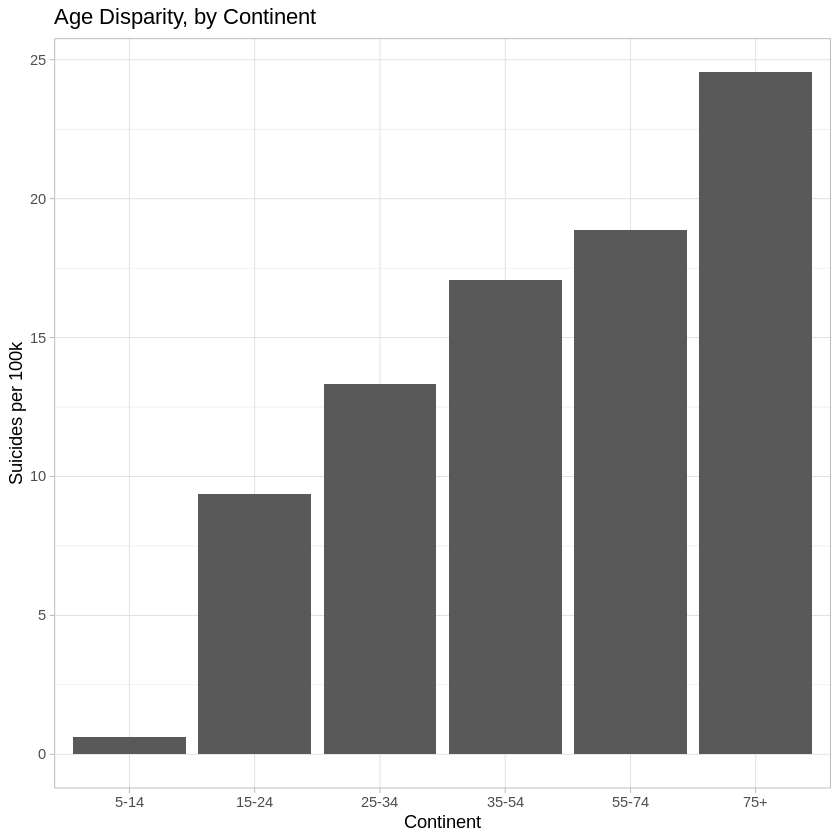

In [ ]:
data %>%
  group_by( age) %>%
  summarize(n = n(), 
            suicides = sum(as.numeric(suicides_no)), 
            population = sum(as.numeric(population)), 
            suicide_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = age, y = suicide_per_100k)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  labs(title = "Age Disparity, by Continent",
       x = "Continent", 
       y = "Suicides per 100k")

`summarise()` has grouped output by 'continent'. You can override using the `.groups` argument.



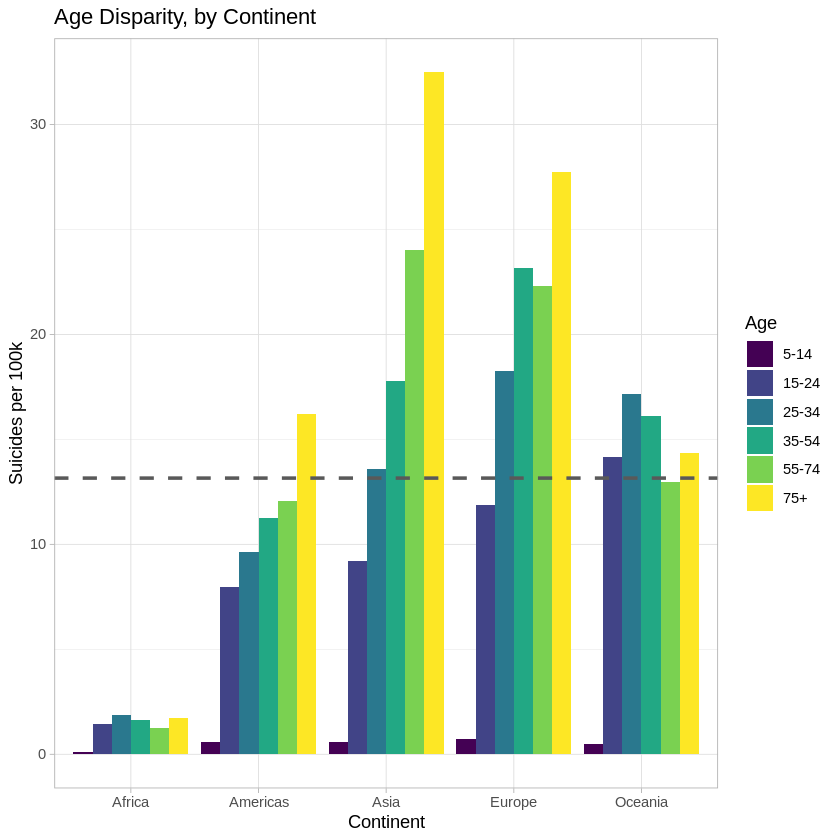

In [ ]:
# Age by continent
data %>%
  group_by(continent, age) %>%
  summarize(n = n(), 
            suicides = sum(as.numeric(suicides_no)), 
            population = sum(as.numeric(population)), 
            suicide_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = continent, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Age Disparity, by Continent",
       x = "Continent", 
       y = "Suicides per 100k", 
       fill = "Age")

In [ ]:
# prepare
demographic_most <- data %>%
  mutate(suicides_per_100k = suicides_no * 100000 / population) %>%
  arrange(desc(suicides_per_100k)) %>% 
  filter(year != 1985) %>%
  head(n = round(nrow(.) * 5 / 100))
  

demographic_most$time <- ifelse(demographic_most$year <= 1995, "1986 - 1995", 
                                ifelse(demographic_most$year <= 2005, "1996 - 2005", 
                                       "2006 - 2015"))

# plot
ggplot(demographic_most, aes(x = age, fill = sex)) + 
  geom_bar() + 
  labs(title = "'High-Risk' Suicide Instances Between 1996 and 2015", 
       subtitle = "Suicide Numbers by Decade, Age & Sex",
       x = "Age", 
       y = "Number of Demographics", 
       fill = "Sex") + 
  facet_wrap(~ time) + 
  scale_y_continuous(breaks = seq(0, 300, 20))

ERROR: ignored

# South Asean


In [ ]:
data %>% filter(continent == "Asia")%>% group_by(country) %>% count() 

country,n
<fct>,<int>
Armenia,288
Azerbaijan,192
Bahrain,252
Cyprus,168
Georgia,264
Israel,372
Japan,372
Kazakhstan,312
Kuwait,300


`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



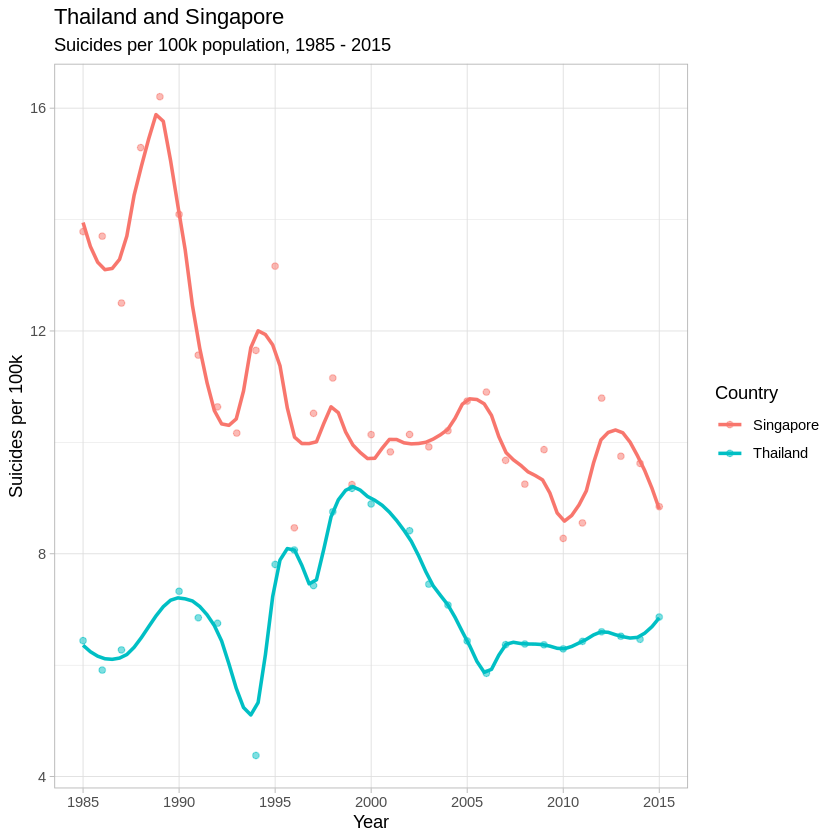

In [ ]:
data_filtered <- data %>%
  filter(country %in% c("Thailand", 
                        "Singapore")) 


data_filtered %>%
  group_by(country, year) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = country)) + 
  geom_point(alpha = 0.5) + 
  geom_smooth(se = F, span = 0.2) + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F) + 
  labs(title = "Thailand and Singapore", 
       subtitle = "Suicides per 100k population, 1985 - 2015", 
       x = "Year", 
       y = "Suicides per 100k", 
       col = "Country")